## Animal 10 Database: Deep Learning CNN Model
There will two deep learning models within this file. The first one will be the custom dl model that would be learning from scratch. The second will be a dl model, imported from online, that utilizes a pretrained model (RESNET) and its weights for learning.

# CUSTOM CNN
This performs the following for the Custom CNN
1. Setup and Intialization
2. Access to Kaggle Database
3. Load and Preprocess Images
4. Split data into training, validation, and test sets
5. Augments the Data

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import kagglehub
from sklearn.model_selection import train_test_split

np.random.seed(42)
tf.random.set_seed(42)

# 1. Access the Kaggle Dataset
path = kagglehub.dataset_download("alessiocorrado99/animals10")
print("Path to dataset files:", path)
print_img_dir = os.listdir(path+"/raw-img")
print("Images extracted to:", print_img_dir)
img_dir = path+"/raw-img"
class_names = sorted(os.listdir(img_dir))
print("Classes found:", class_names)

# 2. Load and Preprocess Images
print("Loading and preprocessing images...")
image_size = (120, 120)  # Resize images to 64x64
data = []
labels = []

for label, class_name in enumerate(class_names):
    class_folder = os.path.join(img_dir, class_name)
    for img_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img / 255.0
            data.append(img)
            labels.append(label)

# Convert to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels, dtype="int32")

print(f"Total images loaded: {len(data)}")

# Compute mean and standard deviation across all images
mean = np.mean(data, axis=(0, 1, 2, 3), keepdims=True)
std = np.std(data, axis=(0, 1, 2, 3), keepdims=True)

# Standardize the images
data = (data - mean) / std

print(f"Data standardized: Mean={np.mean(data):.4f}, Std={np.std(data):.4f}")
print(f"Total images loaded: {len(data)}")

# 3. Split Data into Train, Validation, and Test Sets
X_temp, X_test, y_temp, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_valid)}, Test samples: {len(X_test)}")


# 4. Define ImageDataGenerator for Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2
Images extracted to: ['cavallo', 'mucca', 'gallina', 'scoiattolo', 'pecora', 'farfalla', 'ragno', 'cane', 'elefante', 'gatto']
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Loading and preprocessing images...
Total images loaded: 26179
Data standardized: Mean=-0.0000, Std=1.0000
Total images loaded: 26179
Training samples: 14031, Validation samples: 3508, Test samples: 8640


The following cell performs the following for the Custom CNN:
1. Build the CNN Model
2. Define Callbacks
3. Compile the Model
4. Summarize the Model
5. Train the Model and evaluate on Test Set\

In [6]:


# 5. Build the CNN Model
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=X_train.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=7, restore_best_weights=True
)

# Compile the Model
cnn.compile(loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            metrics=["accuracy"])

cnn.summary()


history = cnn.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, lr_scheduler]
)

# 7. Evaluate the Model on Test Set
test_loss, test_acc = cnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test Loss: {test_loss:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 120, 120, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 120, 120, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 118, 118, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 59, 59, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 59, 59, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 57, 57, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,369,130 (43.37 MB)

 Trainable params: 11,368,682 (43.37 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 218ms/step - accuracy: 0.1981 - loss: 5.7028 - val_accuracy: 0.2243 - val_loss: 3.1276 - learning_rate: 5.0000e-04
Epoch 2/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.2952 - loss: 2.8591 - val_accuracy: 0.3703 - val_loss: 2.5224 - learning_rate: 5.0000e-04
Epoch 3/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.3319 - loss: 2.5672 - val_accuracy: 0.3737 - val_loss: 2.3230 - learning_rate: 5.0000e-04
Epoch 4/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 195ms/step - accuracy: 0.3598 - loss: 2.3561 - val_accuracy: 0.3823 - val_loss: 2.2017 - learning_rate: 5.0000e-04
Epoch 5/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.3928 - loss: 2.1808 - val_accuracy: 0.4361 - val_loss: 1.9424 - learning_rate: 5.0000e-04
Epoch 6/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 193ms/step - accuracy: 0.4368 - loss: 1.9942 - val_accuracy: 0.4860 - val_loss: 1.8082 - learning_rate: 5.0000e-04
Epoch 7/100
220/220 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/s

The last cell for the Custom CNN model performs the following:
1. Predicts the first 10 images in the Test Set
2. Showcases the predictions with the predicted labels and true labels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


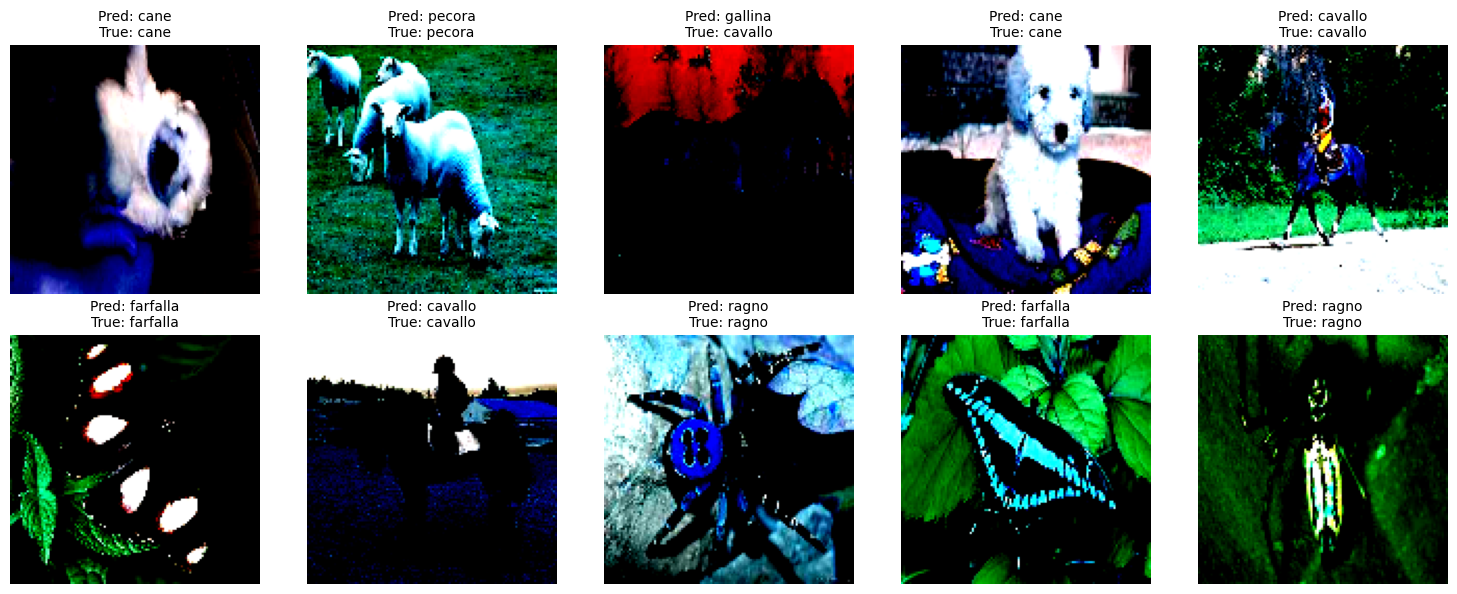

In [7]:
# Predicting the First 10 Images from the Test Set
X_new, y_new = X_test[:10], y_test[:10]  # Select first 10 images from test set
y_pred = np.argmax(cnn.predict(X_new), axis=-1)

# Plot the Predictions
plt.figure(figsize=(15, 6))  # Adjust size to fit more images
for index, image in enumerate(X_new):
    plt.subplot(2, 5, index + 1)  # Arrange in a 2x5 grid
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Pred: {class_names[y_pred[index]]}\nTrue: {class_names[y_new[index]]}", fontsize=10)
plt.tight_layout()
plt.show()


# Pretrained Deep Learning Model: ResNet50
The following cell will perform:
1. Setup and Intialization
2. Access to Kaggle Database
3. Load and Preprocess Images
4. Split data into training, validation, and test sets
5. Loads Pretrained Model ResNet50
6. Trains, Validates, and Tests
7. Visualize Predictions

Path to dataset files: ./data/raw-img
Using device: cuda
The total number of training batches is 524
The total number of validation batches is 131
The total number of test batches is 164
Epoch 1/2, Train Loss: 0.5018, Train Accuracy: 85.07%, Val Loss: 0.2709, Val Accuracy: 91.24%
Epoch 2/2, Train Loss: 0.3236, Train Accuracy: 89.41%, Val Loss: 0.2476, Val Accuracy: 91.55%
Test Loss: 0.2723, Test Accuracy: 91.50%


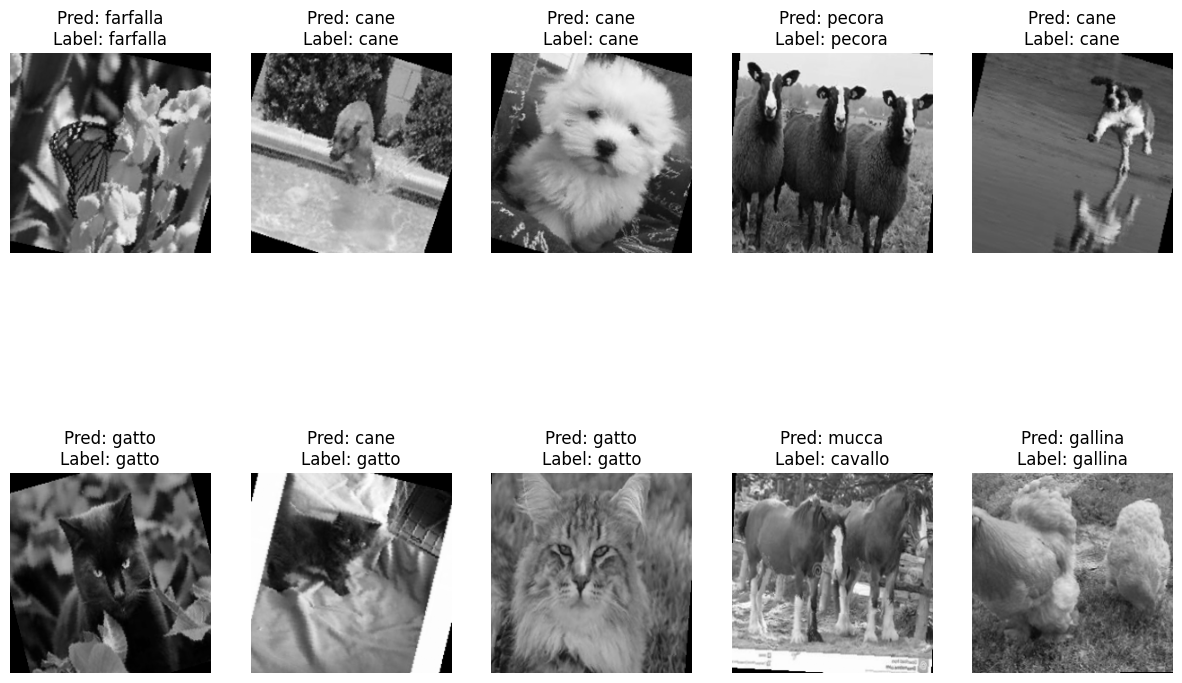

In [8]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import matplotlib.pyplot as plt

# Download and extract dataset
os.system("kaggle datasets download -d alessiocorrado99/animals10 -p ./data")
os.system("unzip -o ./data/animals10.zip -d ./data")
img_dir = "./data/raw-img"
print("Path to dataset files:", img_dir)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data transformations
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset
full_data = datasets.ImageFolder(img_dir, transform=transformer)
train_size = int(len(full_data) * 0.8)
test_size = len(full_data) - train_size
train_data, test_data = random_split(full_data, [train_size, test_size])

# Further split train_data into training and validation sets
val_size = int(len(train_data) * 0.2)
train_data, val_data = random_split(train_data, [len(train_data) - val_size, val_size])

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"The total number of training batches is {len(train_loader)}")
print(f"The total number of validation batches is {len(val_loader)}")
print(f"The total number of test batches is {len(test_loader)}")

# Load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)
for parameters in model.parameters():
    parameters.requires_grad = False  # Freeze pre-trained weights

# Replace the fully connected layer
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust for 10 classes
model = model.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.fc.parameters())

# Training loop with validation
num_epochs = 2
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_correct_train = 0
    running_total_train = 0
    total_loss_train = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = model(features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()

        _, predicted = torch.max(outputs, 1)
        running_correct_train += (predicted == labels).sum().item()
        running_total_train += labels.size(0)
        total_loss_train += loss.item()

    train_accuracy = 100 * running_correct_train / running_total_train
    avg_train_loss = total_loss_train / len(train_loader)

    # Validation phase
    model.eval()
    running_correct_val = 0
    running_total_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            running_correct_val += (predicted == labels).sum().item()
            running_total_val += labels.size(0)
            total_loss_val += loss.item()

    val_accuracy = 100 * running_correct_val / running_total_val
    avg_val_loss = total_loss_val / len(val_loader)

    # Print training and validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# Test phase
model.eval()
running_correct_test = 0
running_total_test = 0
total_loss_test = 0

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = loss_fn(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        running_correct_test += (predicted == labels).sum().item()
        running_total_test += labels.size(0)
        total_loss_test += loss.item()

test_accuracy = 100 * running_correct_test / running_total_test
avg_test_loss = total_loss_test / len(test_loader)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


# Define a function to visualize predictions
def visualize_predictions(model, data_loader, class_names, num_images=10):
    model.eval()  # Set model to evaluation mode
    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    break

                # Convert image tensor to numpy for visualization
                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5)  # Unnormalize

                plt.subplot(2, 5, images_shown + 1)
                plt.imshow(img)
                plt.title(f"Pred: {class_names[preds[i]]}\nLabel: {class_names[labels[i]]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= num_images:
                break
    plt.show()

# Class names
class_names = full_data.classes

# Call the visualization function
visualize_predictions(model, test_loader, class_names)
